<a href="https://colab.research.google.com/github/HelBuk/CMF_Sber_hackathon/blob/main/CMF_sber_XGBoost_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import holidays as hld

In [79]:
orders = pd.read_csv('orders.csv')

In [3]:
partners = pd.read_csv('partners_delays.csv')

In [80]:
#преобразуем столбец 'date' в datetime format
orders['date'] = pd.to_datetime(orders['date'])

In [6]:
partners['dttm'] = pd.to_datetime(partners['dttm'])
partners = partners.set_index('dttm')

In [81]:
#Собираем уникальные delivery_area_id
unique_id = orders['delivery_area_id'].unique()

In [82]:
id_area = 0
df = orders[orders['delivery_area_id'] == id_area]
df

,delivery_area_id,date,orders_cnt
0,0,2021-04-01 10:00:00,9
1,0,2021-04-01 11:00:00,1
2,0,2021-04-01 13:00:00,1
3,0,2021-04-01 14:00:00,1
4,0,2021-04-01 15:00:00,2
...,...,...,...
2834,0,2021-11-30 17:00:00,10
2835,0,2021-11-30 18:00:00,21
2836,0,2021-11-30 19:00:00,10
2837,0,2021-11-30 20:00:00,15


In [83]:
#В DataFrame orders заменим индекты на даты
df = df.set_index('date')
#Добавляем строки, чтобы были данные по каждому часу
df = df.asfreq('H')
df

,delivery_area_id,orders_cnt
date,,
2021-04-01 10:00:00,0.0,9.0
2021-04-01 11:00:00,0.0,1.0
2021-04-01 12:00:00,NaN,NaN
2021-04-01 13:00:00,0.0,1.0
2021-04-01 14:00:00,0.0,1.0
...,...,...
2021-11-30 17:00:00,0.0,10.0
2021-11-30 18:00:00,0.0,21.0
2021-11-30 19:00:00,0.0,10.0


In [84]:
#Заполняем столбец "число заказов" там, где есть пропуски в данных
df['orders_cnt'] = df['orders_cnt'].interpolate()
df['delivery_area_id'] = id_area
df

,delivery_area_id,orders_cnt
date,,
2021-04-01 10:00:00,0,9.0
2021-04-01 11:00:00,0,1.0
2021-04-01 12:00:00,0,1.0
2021-04-01 13:00:00,0,1.0
2021-04-01 14:00:00,0,1.0
...,...,...
2021-11-30 17:00:00,0,10.0
2021-11-30 18:00:00,0,21.0
2021-11-30 19:00:00,0,10.0


In [85]:
df.index.date

array([datetime.date(2021, 4, 1), datetime.date(2021, 4, 1),
       datetime.date(2021, 4, 1), ..., datetime.date(2021, 11, 30),
       datetime.date(2021, 11, 30), datetime.date(2021, 11, 30)],
      dtype=object)

In [93]:
#выделим отдельный DataFrame только с датами
df_dates = pd.Series(df.index, name="date").to_frame().sort_values(by='date')
df_dates

,date
0,2021-04-01 10:00:00
1,2021-04-01 11:00:00
2,2021-04-01 12:00:00
3,2021-04-01 13:00:00
4,2021-04-01 14:00:00
...,...
5839,2021-11-30 17:00:00
5840,2021-11-30 18:00:00
5841,2021-11-30 19:00:00
5842,2021-11-30 20:00:00


In [94]:
#Список праздников
holidays = []
for i in range(1, 11):
  holidays.append(datetime(2021, 1, i).date())
for i in range(21, 24):
  holidays.append(datetime(2021, 2, i).date())
for i in range(6, 9):
  holidays.append(datetime(2021, 3, i).date())
for i in range(1, 4):
  holidays.append(datetime(2021, 5, i).date())
for i in range(8, 11):
  holidays.append(datetime(2021, 5, i).date())
for i in range(12, 15):
  holidays.append(datetime(2021, 6, i).date())
for i in range(4, 8):
  holidays.append(datetime(2021, 11, i).date())
holidays.append(datetime(2021, 12, 31).date())
Holidays = np.array([holidays])

In [95]:
#выделим отдельный DataFrame только с датами праздников
df_holidays = pd.DataFrame({'holidays': holidays})
df_holidays['holidays'] = pd.to_datetime(df_holidays['holidays'])
df_holidays

,holidays
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05
5,2021-01-06
6,2021-01-07
7,2021-01-08
8,2021-01-09
9,2021-01-10


In [96]:
df_dates = pd.merge_asof(df_dates, df_holidays, left_on='date', right_on='holidays', direction='forward')
df_dates

,date,holidays
0,2021-04-01 10:00:00,2021-05-01
1,2021-04-01 11:00:00,2021-05-01
2,2021-04-01 12:00:00,2021-05-01
3,2021-04-01 13:00:00,2021-05-01
4,2021-04-01 14:00:00,2021-05-01
...,...,...
5839,2021-11-30 17:00:00,2021-12-31
5840,2021-11-30 18:00:00,2021-12-31
5841,2021-11-30 19:00:00,2021-12-31
5842,2021-11-30 20:00:00,2021-12-31


In [97]:
df_dates = pd.merge_asof(df_dates, df_holidays, left_on='date', right_on='holidays')
df_dates

,date,holidays_x,holidays_y
0,2021-04-01 10:00:00,2021-05-01,2021-03-08
1,2021-04-01 11:00:00,2021-05-01,2021-03-08
2,2021-04-01 12:00:00,2021-05-01,2021-03-08
3,2021-04-01 13:00:00,2021-05-01,2021-03-08
4,2021-04-01 14:00:00,2021-05-01,2021-03-08
...,...,...,...
5839,2021-11-30 17:00:00,2021-12-31,2021-11-07
5840,2021-11-30 18:00:00,2021-12-31,2021-11-07
5841,2021-11-30 19:00:00,2021-12-31,2021-11-07
5842,2021-11-30 20:00:00,2021-12-31,2021-11-07


In [98]:
#counting days until and before some official holiday day for orders

df_dates['days_until_holiday'] = df_dates.pop('holidays_x').sub(df_dates['date']).dt.days
df_dates['days_since_holiday'] = df_dates['date'].sub(df_dates.pop('holidays_y')).dt.days

df_dates = df_dates.drop_duplicates()
df_dates

,date,days_until_holiday,days_since_holiday
0,2021-04-01 10:00:00,29,24
1,2021-04-01 11:00:00,29,24
2,2021-04-01 12:00:00,29,24
3,2021-04-01 13:00:00,29,24
4,2021-04-01 14:00:00,29,24
...,...,...,...
5839,2021-11-30 17:00:00,30,23
5840,2021-11-30 18:00:00,30,23
5841,2021-11-30 19:00:00,30,23
5842,2021-11-30 20:00:00,30,23


In [99]:
df = pd.merge(df, df_dates, how='left', on='date')
df

,date,delivery_area_id,orders_cnt,days_until_holiday,days_since_holiday
0,2021-04-01 10:00:00,0,9.0,29,24
1,2021-04-01 11:00:00,0,1.0,29,24
2,2021-04-01 12:00:00,0,1.0,29,24
3,2021-04-01 13:00:00,0,1.0,29,24
4,2021-04-01 14:00:00,0,1.0,29,24
...,...,...,...,...,...
5839,2021-11-30 17:00:00,0,10.0,30,23
5840,2021-11-30 18:00:00,0,21.0,30,23
5841,2021-11-30 19:00:00,0,10.0,30,23
5842,2021-11-30 20:00:00,0,15.0,30,23


In [100]:
#В DataFrame orders заменим индекты на даты
df = df.set_index('date')
#Добавляем строки, чтобы были данные по каждому часу
df = df.asfreq('H')
df

,delivery_area_id,orders_cnt,days_until_holiday,days_since_holiday
date,,,,
2021-04-01 10:00:00,0,9.0,29,24
2021-04-01 11:00:00,0,1.0,29,24
2021-04-01 12:00:00,0,1.0,29,24
2021-04-01 13:00:00,0,1.0,29,24
2021-04-01 14:00:00,0,1.0,29,24
...,...,...,...,...
2021-11-30 17:00:00,0,10.0,30,23
2021-11-30 18:00:00,0,21.0,30,23
2021-11-30 19:00:00,0,10.0,30,23


In [17]:
p = np.array(list(map(lambda x: 1 if x in Holidays else 0, df.index.date)))
len(p)

5844

In [101]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(np.int64)
    #Добавляем данные о праздниках (0/1)
    df['Holidays'] = np.array(list(map(lambda x: 1 if x in Holidays else 0, df.index.date)))
    #Добавляем отдельно столбец с единицей, если время вне интервала с 10:00 до 20:00
    df['early_late_h'] = np.array(list(map(lambda x: 1 if x in list(range(0, 10))+list(range(21, 24)) else 0,  df.index.hour)))
    #Если выходной, то 1
    df['weekend'] = np.array(list(map(lambda x: 1 if x in [5, 6] else 0, df.index.dayofweek)))
    
    return df

df = create_features(df)

In [104]:
df

,delivery_area_id,orders_cnt,days_until_holiday,days_since_holiday,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Holidays,early_late_h,weekend
date,,,,,,,,,,,,,,,
2021-04-01 10:00:00,0,9.0,29,24,10,3,2,4,2021,91,1,13,0,0,0
2021-04-01 11:00:00,0,1.0,29,24,11,3,2,4,2021,91,1,13,0,0,0
2021-04-01 12:00:00,0,1.0,29,24,12,3,2,4,2021,91,1,13,0,0,0
2021-04-01 13:00:00,0,1.0,29,24,13,3,2,4,2021,91,1,13,0,0,0
2021-04-01 14:00:00,0,1.0,29,24,14,3,2,4,2021,91,1,13,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 17:00:00,0,10.0,30,23,17,1,4,11,2021,334,30,48,0,0,0
2021-11-30 18:00:00,0,21.0,30,23,18,1,4,11,2021,334,30,48,0,0,0
2021-11-30 19:00:00,0,10.0,30,23,19,1,4,11,2021,334,30,48,0,0,0


In [105]:
train_size = int(len(df) * .9)
train, test = df[:train_size], df[train_size + 1:]

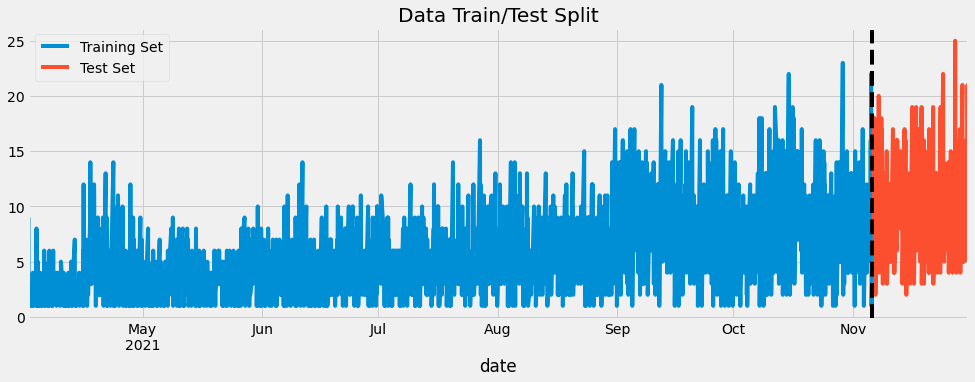

In [106]:
fig, ax = plt.subplots(figsize=(15, 5))
train['orders_cnt'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['orders_cnt'].plot(ax=ax, label='Test Set')
ax.axvline('11-06-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

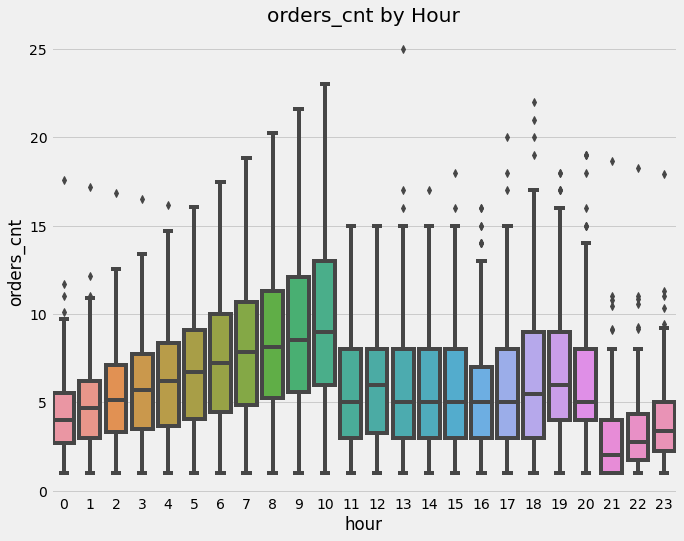

In [107]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='orders_cnt')
ax.set_title('orders_cnt by Hour')
plt.show()

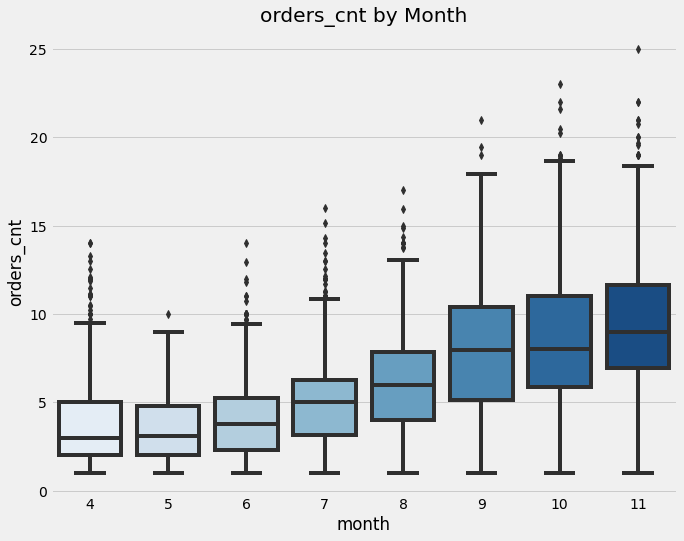

In [108]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='orders_cnt', palette='Blues')
ax.set_title('orders_cnt by Month')
plt.show()

In [109]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter',
       'month', 'dayofyear', 'dayofmonth', 'weekofyear', 'Holidays',
       'early_late_h', 'weekend']
TARGET = 'orders_cnt'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [110]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[11:33:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.13096	validation_1-rmse:9.99429
[100]	validation_0-rmse:3.22317	validation_1-rmse:5.48999
[200]	validation_0-rmse:2.48951	validation_1-rmse:4.01963
[300]	validation_0-rmse:2.30955	validation_1-rmse:3.59592
[400]	validation_0-rmse:2.24309	validation_1-rmse:3.47428
[500]	validation_0-rmse:2.2089	validation_1-rmse:3.55692
[600]	validation_0-rmse:2.1836	validation_1-rmse:3.6651
[700]	validation_0-rmse:2.16276	validation_1-rmse:3.75361
[800]	validation_0-rmse:2.14083	validation_1-rmse:3.81665
[900]	validation_0-rmse:2.12147	validation_1-rmse:3.85783
[999]	validation_0-rmse:2.10622	validation_1-rmse:3.88757


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

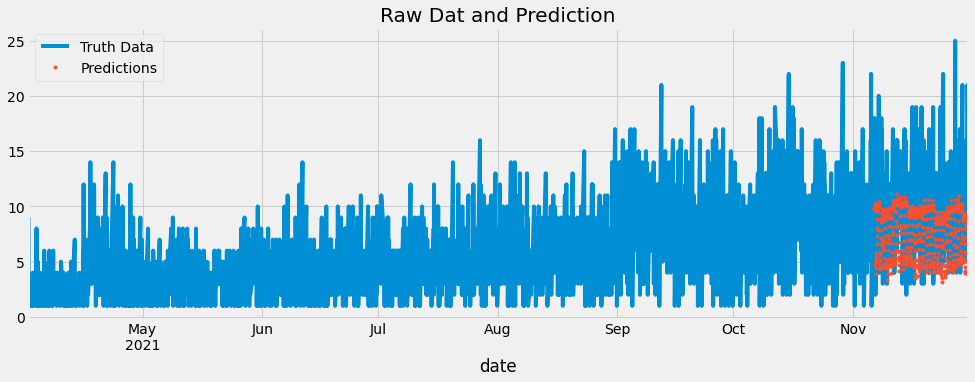

In [111]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['orders_cnt']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

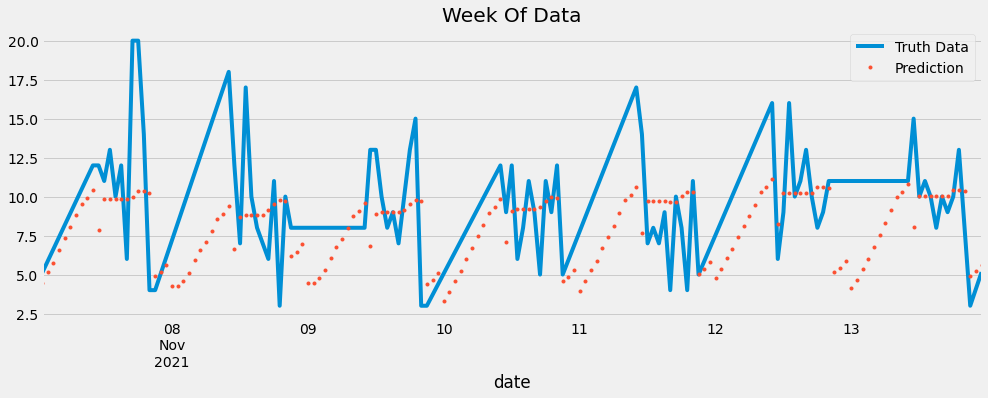

In [112]:
ax = df.loc[(df.index > '11-07-2021') & (df.index < '11-14-2021')]['orders_cnt'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '11-07-2021') & (df.index < '11-14-2021')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [113]:
score = np.sqrt(mean_squared_error(test['orders_cnt'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3.89


In [114]:
test

,delivery_area_id,orders_cnt,days_until_holiday,days_since_holiday,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Holidays,early_late_h,weekend,prediction
date,,,,,,,,,,,,,,,,
2021-11-06 14:00:00,0,8.0,0,0,14,5,4,11,2021,310,6,44,1,0,1,9.744791
2021-11-06 15:00:00,0,18.0,0,0,15,5,4,11,2021,310,6,44,1,0,1,9.744791
2021-11-06 16:00:00,0,8.0,0,0,16,5,4,11,2021,310,6,44,1,0,1,9.718229
2021-11-06 17:00:00,0,6.0,0,0,17,5,4,11,2021,310,6,44,1,0,1,9.860338
2021-11-06 18:00:00,0,6.0,0,0,18,5,4,11,2021,310,6,44,1,0,1,10.250731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 17:00:00,0,10.0,30,23,17,1,4,11,2021,334,30,48,0,0,0,8.281391
2021-11-30 18:00:00,0,21.0,30,23,18,1,4,11,2021,334,30,48,0,0,0,8.665783
2021-11-30 19:00:00,0,10.0,30,23,19,1,4,11,2021,334,30,48,0,0,0,8.892859


In [115]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date_only'] = test.index.date
test.groupby(['date_only'])['error'].mean().sort_values(ascending=False).head(10)

date_only
2021-11-24    5.754578
2021-11-30    4.549359
2021-11-17    4.498003
2021-11-08    4.218044
2021-11-16    4.117538
2021-11-29    4.040682
2021-11-11    3.563834
2021-11-06    3.497039
2021-11-27    3.418990
2021-11-12    3.135669
Name: error, dtype: float64